In [8]:
from collections import defaultdict
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os 

from tqdm import tqdm
# from superimpose import calculate_rg, run_tmscore
from collections import Counter
from scipy.stats import spearmanr, pearsonr
from scipy.optimize import curve_fit
from scipy.stats import hmean
from sklearn.metrics import auc
from matplotlib import rcParams
import matplotlib.lines as mlines
from utils import read_fasta, calculate_rg, run_tmscore
from scipy.stats import mannwhitneyu

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] + plt.rcParams['font.sans-serif']
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'

In [9]:
fig_dir = '../data/figures'
os.makedirs(fig_dir, exist_ok=True)

data_dir = '../data'

In [10]:
def load_ids(file):
    with open(file, 'r') as f:
        ids = [line.strip() for line in f]
    return ids


def custom_dict():
    return {"target": None, "AlphaFold2-rsa_f1": None, "AlphaFold2-plddt_f1": None, "AlphaFold3-rsa_f1": None, "AlphaFold3-plddt_f1": None}

def bootstrap_ci(x, y, n_bootstraps=1000, ci=95):
    n = len(x)
    corrs = []
    for _ in range(n_bootstraps):
        idx = np.random.choice(np.arange(n), size=n, replace=True)
        corr, _ = pearsonr(np.array(x)[idx], np.array(y)[idx])
        corrs.append(corr)
    lower = np.percentile(corrs, (100 - ci) / 2)
    upper = np.percentile(corrs, 100 - (100 - ci) / 2)
    std = np.std(corrs)
    return lower, upper, std


def calculate_binary_state(score,thr):
    if score >= thr:
        return 1
    else:
        return 0

def read_caid_file(file_path, thr):
    results = []
    acc = ''
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('>'):
                acc = line.strip()[1:]
            else:
                pos, aa, score = line.strip().split()
                state = calculate_binary_state(float(score), thr)
                results.append((acc, int(pos), aa, float(score), state))
    return results

def compute_label(row, method):
    if int(row['label']) == 1 and row[method] == 1:
        return 'TP'
    elif int(row['label']) == 1 and row[method] == 0:
        return 'FN'
    elif int(row['label']) == 0 and row[method] == 1:
        return 'FP'
    elif int(row['label']) == 0 and row[method] == 0:
        return 'TN'
    
def compute_confusion_matrix(values1, values2, rownames, colnames):
    conf_mat = pd.crosstab(values1, values2, rownames=[rownames], colnames=[colnames])
    labels = sorted(set(conf_mat.index).union(set(conf_mat.columns)))
    conf_mat = conf_mat.reindex(index=labels, columns=labels, fill_value=0)

    # Get diagonal values (only works if rows and columns are aligned)
    diag_values = np.array([conf_mat.loc[l, l] for l in labels])

    # Sort labels by diagonal values (descending)
    sorted_labels = [label for _, label in sorted(zip(-diag_values, labels))]

    # Reorder rows and columns
    conf_mat_sorted = conf_mat.loc[sorted_labels, sorted_labels]
    return conf_mat_sorted

def draw_confusion_matrix(conf_mat, output_file,text_size=10,figsize=(4,4)):
    plt.figure(figsize=figsize)
    ax=sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',annot_kws={"size": text_size})
    ax.xaxis.set_label_position("top")
    plt.tick_params(axis='both', which='major', labelsize=text_size, labelbottom = False, bottom=False, top = False, labeltop=True)

    plt.tight_layout()
    
    plt.savefig(output_file, dpi=300)
    plt.show()
    plt.close()

def make_path(directory,acc):
    if os.path.exists(os.path.join(directory,f'{acc}.cif')):
        return os.path.join(directory,f'{acc}.cif')
    elif os.path.exists(os.path.join(directory,f'{acc}.pdb')):
        return os.path.join(directory,f'{acc}.pdb')

# CAID disorder results

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


[('AlphaFold2-rsa', '0.95'), ('AlphaFold3-rsa', '0.948'), ('AlphaFold2-plddt', '0.934'), ('AlphaFold3-plddt', '0.932')]


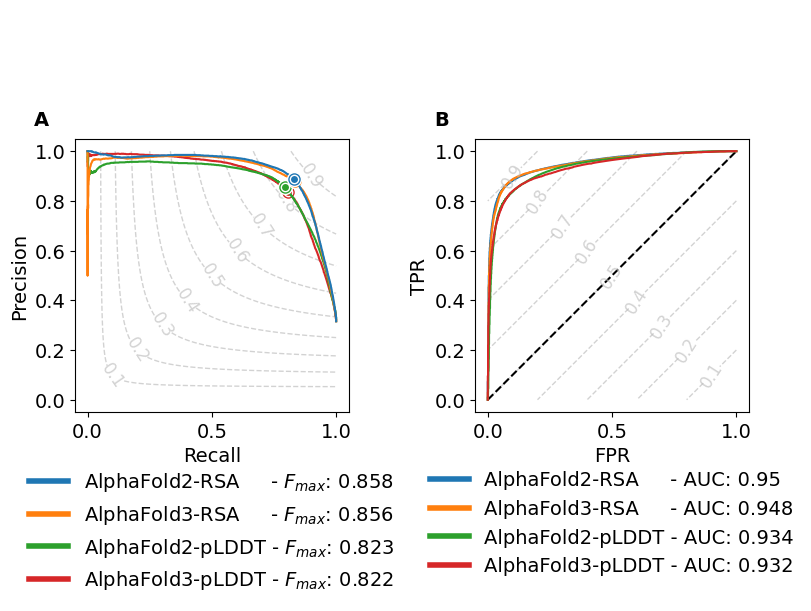

In [11]:
def plot_roc(preds_rocs, ax=None):
    r = np.linspace(0, 1, 1000)
    fs = np.mean(np.array(np.meshgrid(r, r)).T.reshape(-1, 2), axis=1).reshape(1000, 1000)
    cs = ax.contour(r[::-1], r, fs, levels=np.linspace(0.1, 1, 10), colors='silver', alpha=0.7, linewidths=1,
                    linestyles='--')
    ax.clabel(cs, inline=True, fmt='%.1f', fontsize=12, manual=[(l, 1 - l) for l in cs.levels[:-1]]) # 18

    auc_rocs = sorted(preds_rocs.columns.droplevel(2).unique(), key=lambda t: t[1], reverse=True)[:10]
    print(auc_rocs)
    rocs = preds_rocs.reindex(list(zip(*auc_rocs))[0], axis=1, level=0)
    ax.plot([0, 1], [0, 1], color='k', linestyle='--')

    for p in rocs.columns.get_level_values(0).unique()[:10]:
        ax.plot(*rocs[p].dropna().T.values, label=p)

    
    ax.legend()
    lhandles, llabels = ax.get_legend_handles_labels()

    pwauc = next(zip(*auc_rocs))

    predictor_names = {
        'AlphaFold2-plddt': 'AlphaFold2-pLDDT',
        'AlphaFold2-rsa':   'AlphaFold2-RSA    ',
        'AlphaFold3-plddt': 'AlphaFold3-pLDDT',
        'AlphaFold3-rsa':   'AlphaFold3-RSA    '

    }
    leg = ax.legend(lhandles,
                    ['{}'.format(f'{predictor_names[l]} - AUC: {auc_rocs[pwauc.index(l)][1]}' if l in pwauc else l) for l in llabels],
                    facecolor='w', framealpha=1, edgecolor='w',
                    loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                    ncol=1, fontsize=14) 
    

    for line in leg.get_lines():
        line.set_linewidth(4)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("FPR", fontsize=14)
    ax.set_ylabel("TPR", fontsize=14)
    ax.tick_params(axis='both', labelsize=14)




def plot_pr(pred_prs, sortby="fmax", ax=None):
    auc_pr = sorted(pred_prs.columns.droplevel([2, 3]).unique(), key=lambda t: t[1], reverse=True)
    aps_pr = sorted(pred_prs.columns.droplevel([1, 3]).unique(), key=lambda t: t[1], reverse=True)
    fmax_pr = sorted(((p, hmean(pred_prs[p].dropna().values, axis=1).max().round(3)) for p in
                      pred_prs.columns.get_level_values(0).unique()),
                     key=lambda t: t[1], reverse=True)

    sorter = None
    sorter_name = None
    if sortby == 'auc':
        sorter = auc_pr
        sorter_name = 'AUC'
    elif sortby == 'aps':
        sorter = aps_pr
        sorter_name = 'APS'
    elif sortby == 'fmax':
        sorter = fmax_pr
        sorter_name = '$F_{max}$'

    prcs = pred_prs.reindex(list(zip(*sorter))[0], axis=1, level=0)


    # plot f-score level lines
    r = np.linspace(0, 1, 1000)
    fs = hmean(np.array(np.meshgrid(r, r)).T.reshape(-1, 2), axis=1).reshape(1000, 1000)
    cs = plt.contour(r, r, fs, levels=np.linspace(0.1, 1, 10), colors='silver', alpha=0.7, linewidths=1,
                     linestyles='--')
    ax.clabel(cs, inline=True, fmt='%.1f', fontsize=12, manual=[(l, l) for l in cs.levels[:-1]])
    
    auc_vals = []
    # plot predictor lines and markers
    for p, z in zip(prcs.columns.get_level_values(0).unique()[:10], range(5, 55, 5)):
        fmax_idx = hmean(prcs[p].dropna().T).argmax()
        auc_vals.append(auc(prcs[p].dropna().T.values[0][1:], prcs[p].dropna().T.values[1][1:]))
        lines = ax.plot(*prcs[p].dropna().T.values, label=p, zorder=55 - z)
        ax.plot(*prcs[p].dropna().T.values[:, fmax_idx], color='w', marker='o', markerfacecolor=lines[0].get_color(),
                markersize=10, zorder=55 - z, linewidth=10)
        ax.plot(*prcs[p].dropna().T.values[:, fmax_idx], color='w', marker='o', markerfacecolor=lines[0].get_color(),
                zorder=55 - z, linewidth=10)


    ax.legend()
    lhandles, llabels = ax.get_legend_handles_labels()
    pwauc = next(zip(*sorter))

    predictor_names = {
        'AlphaFold2-plddt': 'AlphaFold2-pLDDT',
        'AlphaFold2-rsa':   'AlphaFold2-RSA    ',
        'AlphaFold3-plddt': 'AlphaFold3-pLDDT',
        'AlphaFold3-rsa':   'AlphaFold3-RSA    '

    }
    leg = ax.legend(lhandles, ['{}'.format(f'{predictor_names[l]} - {sorter_name}: {sorter[pwauc.index(l)][1]}'
                                           if l in pwauc else l) for l in llabels],
                    facecolor='w', framealpha=1, edgecolor='w',
                    loc='upper center' ,bbox_to_anchor=(0.5, -0.15) #
                    , ncol=1, fontsize=14) # upper bbox_to_anchor=(.5, -.1)
    
    
    for line in leg.get_lines():
        line.set_linewidth(4)


    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Recall", fontsize=14)
    ax.set_ylabel("Precision", fontsize=14)
    ax.tick_params(axis='both', labelsize=14)



references = [
    ('disorder_pdb.analysis.all.dataset.default.metrics.csv', 'disorder'),
]


if __name__ == '__main__':
    letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
    letter_size = 14

    predictor_class = pd.read_csv(f'{data_dir}/inputs/predictor_class.csv')
    reference, class_name = references[0]

    class_of_predictor = set(predictor_class[predictor_class[class_name]]['predictor'])
    

    ref_name = reference.split('.')[0]
    references_involved = []
    references_involved += [ref_name]

    predictions_roc = pd.read_csv(f"{data_dir}/disorder_prediction/caid_results/disorder_pdb.analysis.all.dataset._.roc.csv",
                                          index_col=[0],
                                          header=[0, 1, 2])
    
    predictions_roc = predictions_roc.drop(columns=[p for p in predictions_roc.columns.get_level_values(0)
                                                            if p not in class_of_predictor], level=0)


    predictions_pr = pd.read_csv(f"{data_dir}/disorder_prediction/caid_results/disorder_pdb.analysis.all.dataset._.pr.csv", index_col=[0],
                                    header=[0, 1, 2, 3])
    
 
    predictions_pr = predictions_pr.drop(columns=[p for p in predictions_pr.columns.get_level_values(0)
                                                    if p not in class_of_predictor], level=0)


    ref_num = 0
    
    fig, axs = plt.subplots(figsize=(8,6), layout='constrained') ## 29, 23 constrained
    rcParams['font.size'] = 14 # 22
    gs = fig.add_gridspec(len(references[:2]), 4)

    ax = plt.subplot(gs[ref_num, :2])
    ax.set_facecolor((1.0, 1, 1))
    # ax.spines[['right', 'top']].set_visible(False)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    # take letters 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22
    ax.text(-0.15, 1.05, letters[ref_num * 2], transform=ax.transAxes, size=letter_size, weight='bold')
    ax.set_box_aspect(1)

    plot_pr(predictions_pr, sortby='fmax', ax=ax)

    ax = plt.subplot(gs[ref_num, 2:])
    ax.set_facecolor((1.0, 1, 1))
    # ax.spines[['right', 'top']].set_visible(False)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    ax.text(-0.15, 1.05, letters[ref_num * 2 + 1], transform=ax.transAxes, size=letter_size, weight='bold')

    ax.set_box_aspect(1)
    plot_roc(predictions_roc, ax=ax)

    axs.spines[['right', 'top','left','bottom']].set_visible(False)
    axs.set_xticks([])
    axs.set_yticks([])
    # plt.axis('off')
    plt.savefig(f'{data_dir}/figures/figure_1_A_B.png', dpi=300)
    plt.show()
    plt.close()


# Average pLDDT and RSA in disordered regions

In [12]:
target_df = pd.read_csv(f'{data_dir}/disorder_prediction/caid_results/disorder_pdb.analysis.all.target.f1s.metrics.csv')
target_df.rename(columns={
    'Unnamed: 0' : 'method' ,
    'Unnamed: 1': 'target'    
}, inplace=True)
target_df

,method,target,bac,csi,f05,f1s,f2s,fnr,fom,fpr,inf,mcc,mk,npv,ppv,tnr,tpr,thr
0,AlphaFold2-rsa,DP02732,0.947,0.852,0.878,0.920,0.966,0.000,0.000,0.105,0.895,0.873,0.852,1.000,0.852,0.895,1.000,0.551
1,AlphaFold2-rsa,DP03745,0.814,0.629,0.894,0.772,0.679,0.371,0.131,0.000,0.629,0.739,0.869,0.869,1.000,1.000,0.629,0.551
2,AlphaFold2-rsa,DP03748,0.875,0.750,0.938,0.857,0.789,0.250,0.018,0.000,0.750,0.858,0.982,0.982,1.000,1.000,0.750,0.551
3,AlphaFold2-rsa,DP03749,0.909,0.818,0.957,0.900,0.849,0.182,0.008,0.000,0.818,0.901,0.992,0.992,1.000,1.000,0.818,0.551
4,AlphaFold2-rsa,DP03758,0.983,0.975,0.980,0.987,0.995,0.000,0.000,0.035,0.965,0.970,0.975,1.000,0.975,0.965,1.000,0.551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271,AlphaFold3-rsa,DP04397,0.489,0.000,0.000,0.000,0.000,1.000,0.013,0.021,-0.021,-0.017,-0.013,0.987,0.000,0.979,0.000,0.535
1272,AlphaFold3-rsa,DP04398,0.496,0.000,0.000,0.000,0.000,1.000,0.401,0.009,-0.009,-0.059,-0.401,0.599,0.000,0.991,0.000,0.535
1273,AlphaFold3-rsa,DP04399,0.950,0.900,0.978,0.947,0.918,0.100,0.037,0.000,0.900,0.931,0.963,0.963,1.000,1.000,0.900,0.535
1274,AlphaFold3-rsa,DP04401,0.010,0.010,0.048,0.020,0.012,0.990,1.000,NaN,NaN,0.000,0.000,0.000,1.000,NaN,0.010,0.535


In [13]:
metrics = defaultdict(custom_dict)
for i, row in target_df.iterrows():
    target = row['target']
    method = row['method']
    f1 = row['f1s']
    mcc = row['mcc'] 
    metrics[target].update({'target': target , f'{method}_f1': f1})

metrics_df = pd.DataFrame(list(metrics.values()))
metrics_df

,target,AlphaFold2-rsa_f1,AlphaFold2-plddt_f1,AlphaFold3-rsa_f1,AlphaFold3-plddt_f1
0,DP02732,0.920,0.722,0.657,0.606
1,DP03745,0.772,0.445,0.750,0.490
2,DP03748,0.857,0.880,0.909,0.880
3,DP03749,0.900,0.842,0.952,0.750
4,DP03758,0.987,0.959,0.987,0.925
...,...,...,...,...,...
314,DP04397,0.000,0.727,0.000,0.588
315,DP04398,0.000,0.032,0.000,0.032
316,DP04399,0.940,0.956,0.947,0.960
317,DP04401,0.020,0.162,0.020,0.129


In [14]:
metrics_df[metrics_df['target'] == 'DP04016']

,target,AlphaFold2-rsa_f1,AlphaFold2-plddt_f1,AlphaFold3-rsa_f1,AlphaFold3-plddt_f1
80,DP04016,0.944,0.966,0.834,0.936


In [15]:
metrics_df.shape

(319, 5)

Pearson correlation: 0.8402823774435535, p-value: 2.7649704359381788e-86
Pearson correlation: 0.9389747939709476, p-value: 5.776119720277612e-149


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


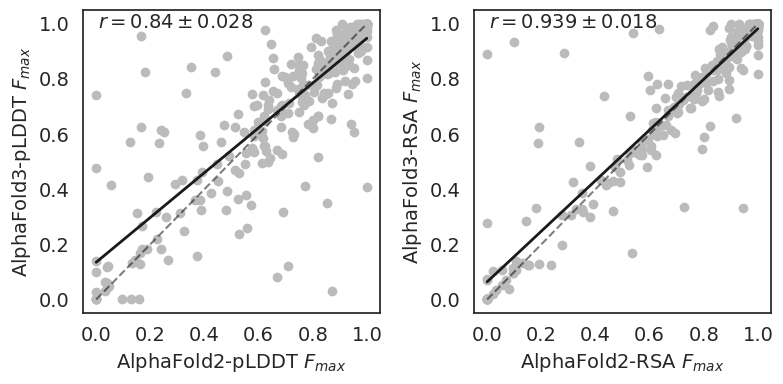

In [16]:
sns.set_theme(style="white")
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)


r,p_value= pearsonr(metrics_df['AlphaFold2-plddt_f1'].tolist(), metrics_df['AlphaFold3-plddt_f1'].tolist())
print(f'Pearson correlation: {r}, p-value: {p_value}')
ci_lower, ci_upper, std = bootstrap_ci(metrics_df['AlphaFold2-plddt_f1'].tolist(), metrics_df['AlphaFold3-plddt_f1'].tolist())

# sns.regplot(x=metrics_df['AlphaFold2-plddt_f1'], y=metrics_df['AlphaFold3-plddt_f1'], scatter_kws={'color':'#BBBBBB'},line_kws={'color':'black'},ci=None) #  scatter_kws={'alpha':0.6}
x = np.linspace(0,1,100)
popt,_ = curve_fit(lambda x,a,b : a*x+b,metrics_df['AlphaFold2-plddt_f1'].tolist(), metrics_df['AlphaFold3-plddt_f1'].tolist())
plt.plot(x,popt[0]*x+popt[1],lw=2,label='$r={:.2f}$'.format(round(r,3)),zorder=4,color='k')
plt.scatter(metrics_df['AlphaFold2-plddt_f1'],metrics_df['AlphaFold3-plddt_f1'], color='#BBBBBB')
plt.plot([0, 1], [0, 1], linestyle='--', color='black', alpha=0.5)
plt.text(0.05, 0.99, '$r={:g} \pm {:g}$'.format(round(r,3),round(std,3)), transform=plt.gca().transAxes,
         fontsize=14, verticalalignment='top', horizontalalignment='left')
plt.ylabel('AlphaFold3-pLDDT '+'$F_{max}$',fontsize=14)
plt.xlabel('AlphaFold2-pLDDT '+'$F_{max}$',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(1, 2, 2)
# plt.scatter(metrics_df['AlphaFold2-rsa_f1'], metrics_df['AlphaFold3-rsa_f1'],  alpha=0.5)

r,p_value = pearsonr(metrics_df['AlphaFold2-rsa_f1'].tolist(), metrics_df['AlphaFold3-rsa_f1'].tolist())
print(f'Pearson correlation: {r}, p-value: {p_value}')
ci_lower, ci_upper, std = bootstrap_ci(metrics_df['AlphaFold2-rsa_f1'].tolist(), metrics_df['AlphaFold3-rsa_f1'].tolist())
popt,_ = curve_fit(lambda x,a,b : a*x+b,metrics_df['AlphaFold2-rsa_f1'].tolist(), metrics_df['AlphaFold3-rsa_f1'].tolist())
x = np.linspace(0,1,100)
plt.plot(x,popt[0]*x+popt[1],lw=2,label='$r={:.2f}$'.format(round(r,3)),zorder=4,color='k')
plt.scatter(metrics_df['AlphaFold2-rsa_f1'],metrics_df['AlphaFold3-rsa_f1'], color='#BBBBBB')
# sns.regplot(x=metrics_df['AlphaFold2-rsa_f1'], y=metrics_df['AlphaFold3-rsa_f1'], scatter_kws={'color':'#BBBBBB','alpha':0.8},line_kws={'color':'black'},ci=None) #  scatter_kws={'alpha':0.6}
plt.plot([0, 1], [0, 1], linestyle='--', color='black', alpha=0.5)

plt.text(0.05, 0.99, '$r={:g} \pm {:g}$'.format(round(r,3),round(std,3)), transform=plt.gca().transAxes,
         fontsize=14, verticalalignment='top', horizontalalignment='left')

plt.ylabel(f'AlphaFold3-RSA '+'$F_{max}$',fontsize=14)
plt.xlabel(f'AlphaFold2-RSA '+'$F_{max}$',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('../data/figures/figure_1_C_D.png', dpi=300)
plt.show()
plt.close()

# Confusion matrices from CAID3 results

In [17]:
thresholds = target_df[['method','thr']].drop_duplicates().set_index('method')['thr'].to_dict()
print(thresholds)

{'AlphaFold2-rsa': 0.551, 'AlphaFold2-plddt': 0.317, 'AlphaFold3-plddt': 0.234, 'AlphaFold3-rsa': 0.535}


In [18]:
af2_rsa_path = f'{data_dir}/disorder_prediction/predictions/disorder/AlphaFold2-rsa.caid'
af2_plddt_path = f'{data_dir}/disorder_prediction/predictions/disorder/AlphaFold2-plddt.caid'
af3_rsa_path = f'{data_dir}/disorder_prediction/predictions/disorder/AlphaFold3-rsa.caid'
af3_plddt_path = f'{data_dir}/disorder_prediction/predictions/disorder/AlphaFold3-plddt.caid'
af2_rsa_thr , af2_plddt_thr ,  af3_rsa_thr, af3_plddt_thr, = 0.551, 0.317, 0.535, 0.234

In [19]:
af2_rsa_df = pd.DataFrame(read_caid_file(af2_rsa_path, af2_rsa_thr), columns=['acc', 'pos', 'aa', 'score_af2-rsa', 'af2-rsa-state'])
af2_plddt_df = pd.DataFrame(read_caid_file(af2_plddt_path, af2_plddt_thr), columns=['acc', 'pos', 'aa', 'score_af2-plddt', 'af2-plddt-state'])
af3_rsa_df = pd.DataFrame(read_caid_file(af3_rsa_path, af3_rsa_thr), columns=['acc', 'pos', 'aa', 'score_af3-rsa', 'af3-rsa-state'])
af3_plddt_df = pd.DataFrame(read_caid_file(af3_plddt_path, af3_plddt_thr), columns=['acc', 'pos', 'aa', 'score_af3-plddt', 'af3-plddt-state'])

In [20]:
disorder_pdb = read_fasta(f'{data_dir}/inputs/disorder_pdb/disorder_pdb.fasta')
disorder_pdb_list = [(acc, pos+1, aa , label) for acc, values in disorder_pdb.items() for pos, (aa, label) in enumerate(zip(values['sequence'],values['labels']))] 
disorder_pdb_df = pd.DataFrame(disorder_pdb_list, columns=['acc', 'pos', 'aa', 'label'])

In [21]:
disorder_pdb_df = disorder_pdb_df.merge(af2_rsa_df, on=['acc', 'pos', 'aa'], how='left')
disorder_pdb_df = disorder_pdb_df.merge(af2_plddt_df, on=['acc', 'pos', 'aa'], how='left')
disorder_pdb_df = disorder_pdb_df.merge(af3_rsa_df, on=['acc', 'pos', 'aa'], how='left')
disorder_pdb_df = disorder_pdb_df.merge(af3_plddt_df, on=['acc', 'pos', 'aa'], how='left')
disorder_pdb_df = disorder_pdb_df[~(disorder_pdb_df['label'] == '-')]

In [22]:
disorder_pdb_df['af2_rsa'] = disorder_pdb_df.apply(compute_label, axis=1, method='af2-rsa-state')
disorder_pdb_df['af2_plddt'] = disorder_pdb_df.apply(compute_label, axis=1, method='af2-plddt-state')
disorder_pdb_df['af3_rsa'] = disorder_pdb_df.apply(compute_label, axis=1, method='af3-rsa-state')
disorder_pdb_df['af3_plddt'] = disorder_pdb_df.apply(compute_label, axis=1, method='af3-plddt-state')

In [23]:
disorder_pdb_df[['acc', 'pos', 'aa', 'label', 'af2_rsa', 'af2_plddt', 'af3_rsa', 'af3_plddt']]

,acc,pos,aa,label,af2_rsa,af2_plddt,af3_rsa,af3_plddt
1546,DP02732,1547,L,1,TP,TP,TP,TP
1547,DP02732,1548,E,1,TP,TP,TP,TP
1548,DP02732,1549,P,1,TP,TP,TP,TP
1549,DP02732,1550,P,1,TP,TP,TP,TP
1550,DP02732,1551,L,1,TP,TP,TP,TP
...,...,...,...,...,...,...,...,...
160417,DP04416,93,T,1,TP,FN,TP,FN
160418,DP04416,94,Y,1,TP,TP,TP,FN
160419,DP04416,95,T,1,TP,TP,TP,TP
160420,DP04416,96,G,1,TP,TP,TP,TP


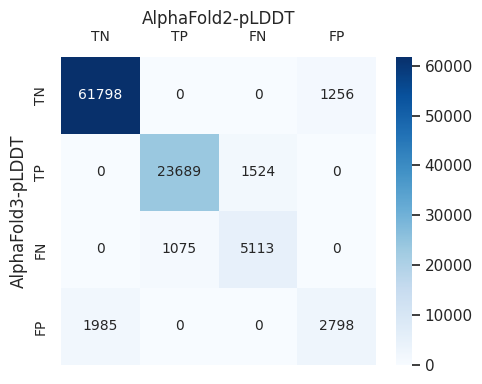

In [24]:
conf_mat = compute_confusion_matrix(disorder_pdb_df['af3_plddt'], disorder_pdb_df['af2_plddt'], 'AlphaFold3-pLDDT', 'AlphaFold2-pLDDT')
draw_confusion_matrix(conf_mat,f'{data_dir}/figures/figure_S_1_A.png',figsize=(5,4))

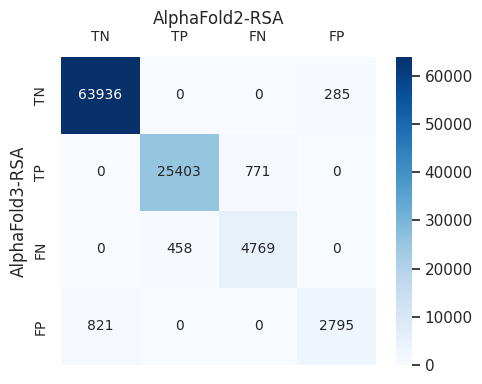

In [25]:
conf_mat = compute_confusion_matrix(disorder_pdb_df['af3_rsa'], disorder_pdb_df['af2_rsa'], 'AlphaFold3-RSA', 'AlphaFold2-RSA')
draw_confusion_matrix(conf_mat, f'{data_dir}/figures/figure_S_1_B.png',figsize=(5,4))